### Load data ###

In [16]:
import pickle

with open('NBA_temporal_dataset.pkl', 'rb') as file:
    temporal_data_dict = pickle.load(file)

X_primary = temporal_data_dict['X_primary']
X_opposing = temporal_data_dict['X_opposing'] 
y = temporal_data_dict['y']

print(X_primary.shape)
print(X_opposing.shape)
print(y.shape)

(83178, 5, 42)
(83178, 5, 42)
(83178, 1)


In [17]:
import numpy as np

X = np.concatenate((X_primary, X_opposing), axis=2)
print(X.shape)
print(y.shape)

(83178, 5, 84)
(83178, 1)


In [18]:
import torch

X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

# print(X_torch[1])

In [19]:
from torch.utils.data import Dataset, DataLoader

class NBADataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [20]:
from torch.utils.data import random_split

dataset = NBADataset(X_torch, y_torch)

train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [21]:
# Check if loader is loading properly

for xb, yb in train_loader:
    print("Batch X:", xb.shape)  # should be [batch_size, 5, 42*2] 
    print("Batch y:", yb.shape)  # should be [batch_size, 1] 
    break

Batch X: torch.Size([1024, 5, 84])
Batch y: torch.Size([1024, 1])


## Create LSTM module ##

In [22]:
import torch.nn as nn

class NBA_LSTM(nn.Module):
    def __init__(self, input_size=84, hidden_size=128, num_layers=2, dropout=0.3):
        super(NBA_LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)  # Binary classification
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out shape: [batch, seq_len, hidden_size]
        last_time_step = lstm_out[:, -1, :]  # take output at the last timestep
        output = self.fc(last_time_step)
        return output


In [23]:
# Function to train and test model 
import time


def AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    time_to_train_per_epoch_list = []

    model.to(device)

    for epoch in range(epochs):
        # Set current epoch train loss, train accuracy and test accuracy to 0.0
        train_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0
        time_per_epoch = 0.0
        # Put model in training mode
        model.train()
        start_time = time.time()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            # Get loss on current batch
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            # Accumulate train loss in epoch
            train_loss += loss.item()
        # Add train loss to train_losses, in order to track
        # print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")
        train_losses.append(train_loss)
        end_time = time.time()
        
        # Calculate time per epoch and accumulate
        time_per_epoch = end_time - start_time
        time_to_train_per_epoch_list.append(time_per_epoch)
        
        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over train dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float().round()
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add train accuracy to train_accuracies
        train_acc = correct / total
        print(f"Epoch {epoch+1}, Training Accuracy: {train_acc}")
        train_accuracies.append(train_acc)

        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over test dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float()
                # print(y_pred)
                # print(y_batch)
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add test accuracy to test_accuracies
        test_acc = correct / total
        print(f"Epoch {epoch+1}, Test Accuracy: {test_acc}")
        test_accuracies.append(test_acc)

    return train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list

In [24]:
# initialize model, optimizer and loss function

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = NBA_LSTM(input_size=X.shape[2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [25]:
# Train and test model 
train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list = AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs = 100)

Epoch 1, Training Accuracy: 0.5709888912043345
Epoch 1, Test Accuracy: 0.5702332291416206
Epoch 2, Training Accuracy: 0.5937835628296171
Epoch 2, Test Accuracy: 0.5919211348881943
Epoch 3, Training Accuracy: 0.6027122773832615
Epoch 3, Test Accuracy: 0.5982688146188988
Epoch 4, Training Accuracy: 0.6071205296314701
Epoch 4, Test Accuracy: 0.6045203173839865
Epoch 5, Training Accuracy: 0.6083388102527932
Epoch 5, Test Accuracy: 0.6055782640057706
Epoch 6, Training Accuracy: 0.6064632992962826
Epoch 6, Test Accuracy: 0.6037509016590527
Epoch 7, Training Accuracy: 0.611176121699822
Epoch 7, Test Accuracy: 0.6063476797307045
Epoch 8, Training Accuracy: 0.6114646618469776
Epoch 8, Test Accuracy: 0.6067804760759798
Epoch 9, Training Accuracy: 0.6112883317570492
Epoch 9, Test Accuracy: 0.6072613609040635
Epoch 10, Training Accuracy: 0.6095570908741164
Epoch 10, Test Accuracy: 0.6048569367636452
Epoch 11, Training Accuracy: 0.6136768029751695
Epoch 11, Test Accuracy: 0.6093772541476317
Epoch 1

Total time to train model: 250.40992856025696
Number of epochs:  100
Average time per epoch:  2.5040992856025697


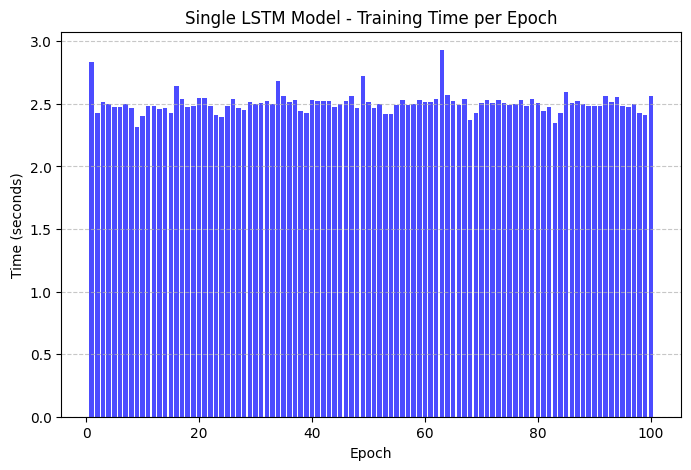

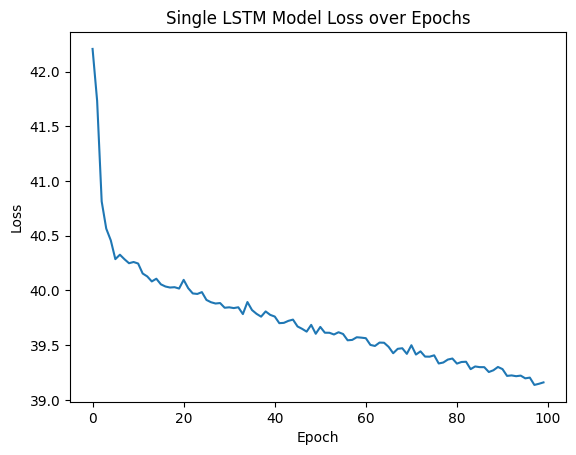

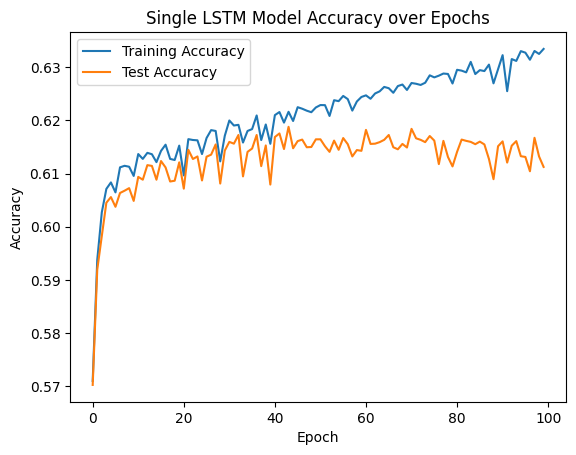

In [26]:
import matplotlib.pyplot as plt

def plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, model_name):

    print(f"Total time to train model: {sum(time_to_train_per_epoch_list)}")

    print("Number of epochs: ", len(time_to_train_per_epoch_list))

    print("Average time per epoch: ", sum(time_to_train_per_epoch_list) / len(time_to_train_per_epoch_list))

    epochs = list(range(1, len(time_to_train_per_epoch_list) + 1))  # Epoch numbers

    plt.figure(figsize=(8, 5))
    plt.bar(epochs, time_to_train_per_epoch_list, color='blue', alpha=0.7)
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title(f"{model_name} - Training Time per Epoch")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(model_name + " Loss over Epochs")
    plt.show()

    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(model_name + " Accuracy over Epochs")
    plt.show()

plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, "Single LSTM Model")

In [27]:
# Function for evaluating model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_ffn_classifier(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs >= 0.5).int().cpu().numpy())
            all_labels.extend(y_batch.int().cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_prediction_distribution_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels).ravel()

    true_win_probs = all_probs[all_labels == 1]
    true_loss_probs = all_probs[all_labels == 0]

    plt.figure(figsize=(8, 5))
    sns.histplot(true_win_probs, color="green", label="True Wins", kde=True, stat="density", bins=30)
    sns.histplot(true_loss_probs, color="red", label="True Losses", kde=True, stat="density", bins=30)

    plt.title(f"{model_name} – Probability Distribution of Predicted Wins")
    plt.xlabel("Predicted Probability of Win")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_roc_curve_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)  # convert logits to probabilities
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve – {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Evaluation for Single LSTM
Accuracy     : 0.6113
Precision    : 0.6295
Recall       : 0.5526
F1 Score     : 0.5886
ROC-AUC Score: 0.6611

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63     10332
           1       0.63      0.55      0.59     10463

    accuracy                           0.61     20795
   macro avg       0.61      0.61      0.61     20795
weighted avg       0.61      0.61      0.61     20795



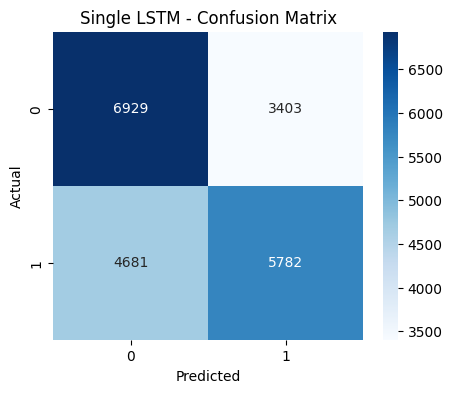

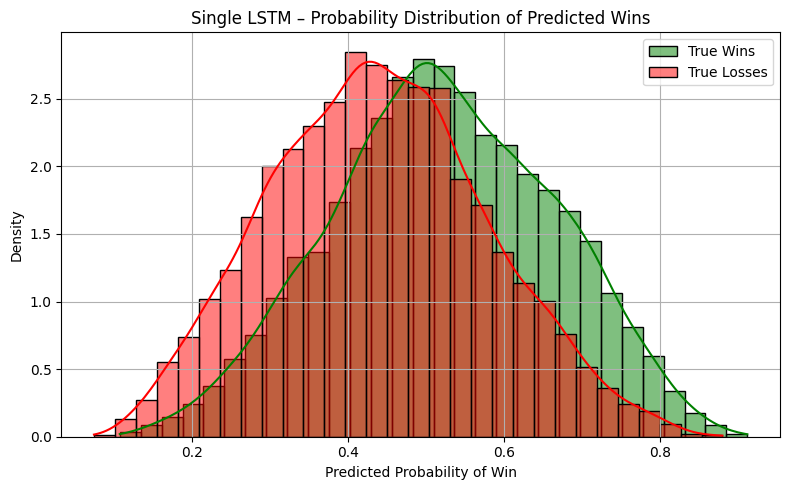

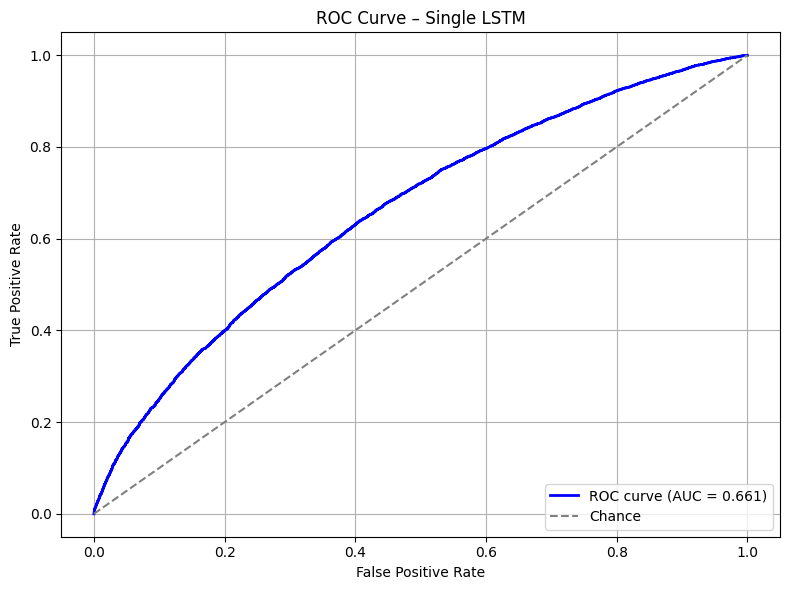

In [28]:
evaluate_ffn_classifier(model, test_dataset, model_name="Single LSTM")
plot_prediction_distribution_ffn(model, test_dataset, model_name="Single LSTM")
plot_roc_curve_ffn(model, test_dataset, model_name="Single LSTM")

### Save the model ###

In [29]:
import os

# Create the directory if it doesn't exist
os.makedirs('models', exist_ok=True)

path = os.path.join('.', 'models', 'single_lstm_model.pth')

# Save the model's state_dict
torch.save(model.state_dict(), path)

In [30]:
import os

# Load the model's state_dict

model = NBA_LSTM(input_size=X.shape[2])
path = os.path.join('.', 'models', 'single_lstm_model.pth')
model.load_state_dict(torch.load(path))
model.eval()

C:\Users\Alex1\AppData\Local\Temp\ipykernel_53984\2286252763.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


NBA_LSTM(
  (lstm): LSTM(84, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [31]:
print(train_accuracies)
print(test_accuracies)
print(time_to_train_per_epoch_list)

[0.5709888912043345, 0.5937835628296171, 0.6027122773832615, 0.6071205296314701, 0.6083388102527932, 0.6064632992962826, 0.611176121699822, 0.6114646618469776, 0.6112883317570492, 0.6095570908741164, 0.6136768029751695, 0.6127630925091772, 0.6139012230896238, 0.6136447429588189, 0.6121539521985156, 0.6142699132776558, 0.615440103874453, 0.6127630925091772, 0.6125547024028982, 0.6152637737845247, 0.6096532709231681, 0.6164820544058478, 0.6163217543240948, 0.6162576342913935, 0.6136768029751695, 0.6166904445121267, 0.61818123527243, 0.6180209351906769, 0.6122982222720934, 0.6171072247246846, 0.6199926261962394, 0.6190468557138964, 0.6191750957792989, 0.6158408540788356, 0.6180209351906769, 0.6183735953705336, 0.6209383966785823, 0.6163057243159195, 0.619239215812, 0.615600403956206, 0.6210025167112835, 0.6215795970055945, 0.6195918759918567, 0.6216276870301204, 0.6198964461471875, 0.6224933074715868, 0.6222047673244313, 0.6218360771363993, 0.6215475369892438, 0.6224452174470609, 0.622894

In [33]:
import csv

def save_training_stats_to_csv(filename, train_acc, test_acc, train_loss, time_per_epoch):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Accuracy", "Test Accuracy", "Train Loss", "Time per Epoch (s)"])

        for epoch in range(len(train_acc)):
            writer.writerow([
                epoch + 1,
                train_acc[epoch],
                test_acc[epoch],
                train_loss[epoch],
                time_per_epoch[epoch]
            ])


save_training_stats_to_csv(
    os.path.join('.', 'training_data' ,'single_lstm.csv'),
    train_accuracies,
    test_accuracies,
    train_losses,
    time_to_train_per_epoch_list
)